In [1]:
# pip install --user torch sympy fsspec
# pip install --user torchvision

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Preparing the Dataset

In [5]:
#train and test data directory
data_dir = "Data_dir/train data/"
test_data_dir = "Data_dir/test data"

transform=transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()])

#load the train and test data
dataset = ImageFolder(data_dir,transform)
test_dataset = ImageFolder(test_data_dir,transform)

# Exploring Images 

In [6]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [7]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['CT_COVID', 'CT_NonCOVID']


Label : CT_COVID


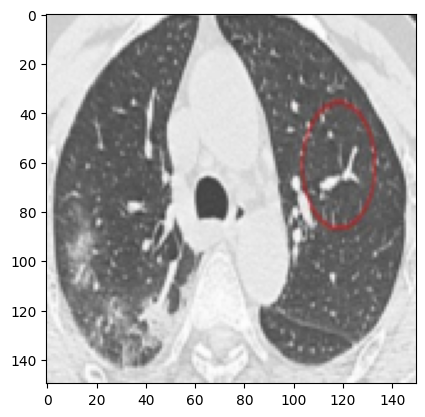

In [8]:
import matplotlib.pyplot as plt

def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

# Splitting Data and Prepare Batches

In [9]:

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = (len(dataset))*20//100
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 479
Length of Validation Data : 119


## Visualizing the images

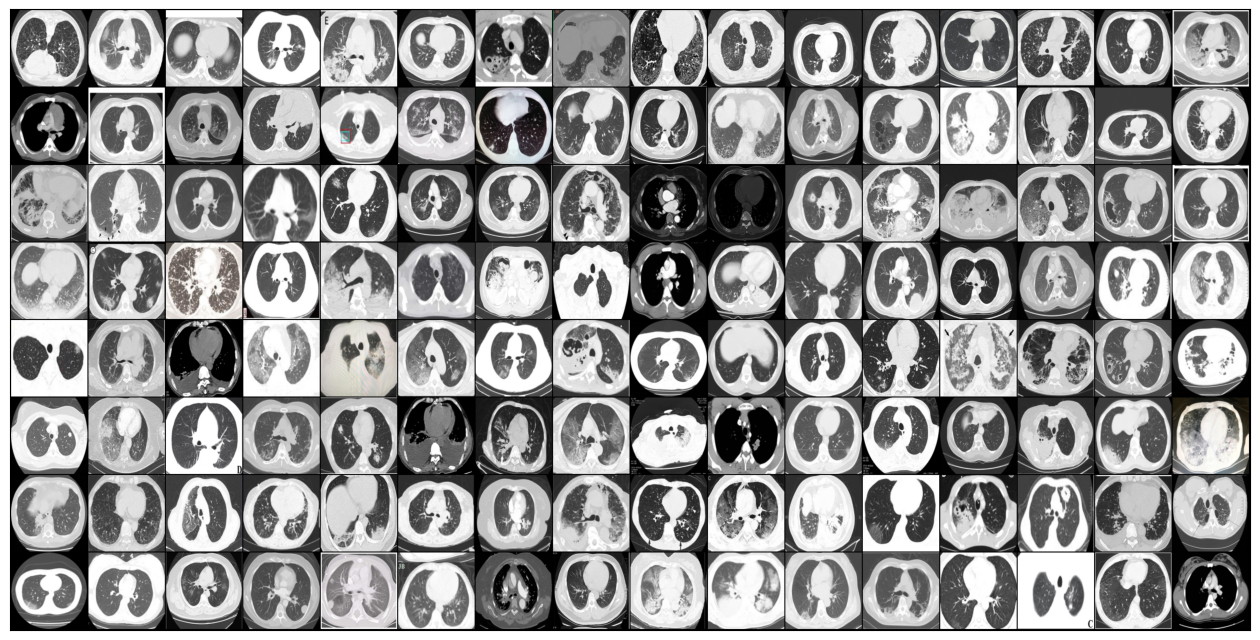

In [10]:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# Base Model For Image Classification

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# CNN Model For Classification

In [12]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

# Hyperparameters, Model Training, And Evaluation

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [14]:
#fitting the model on training data and record the result after each epoch
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

# Define the model
model = NaturalSceneClassification()

# Fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 4.6881, val_loss: 0.7610, val_acc: 0.4286
Epoch [1], train_loss: 1.0938, val_loss: 1.2744, val_acc: 0.4286
Epoch [2], train_loss: 1.2234, val_loss: 1.0434, val_acc: 0.4286
Epoch [3], train_loss: 0.9347, val_loss: 0.7840, val_acc: 0.4286
Epoch [4], train_loss: 0.7175, val_loss: 0.7363, val_acc: 0.5714
Epoch [5], train_loss: 0.7451, val_loss: 0.6926, val_acc: 0.5714
Epoch [6], train_loss: 0.7070, val_loss: 0.7328, val_acc: 0.4286
Epoch [7], train_loss: 0.7159, val_loss: 0.7138, val_acc: 0.4286
Epoch [8], train_loss: 0.6942, val_loss: 0.6840, val_acc: 0.5714
Epoch [9], train_loss: 0.7070, val_loss: 0.6836, val_acc: 0.5714
Epoch [10], train_loss: 0.6973, val_loss: 0.6954, val_acc: 0.4286
Epoch [11], train_loss: 0.6949, val_loss: 0.6998, val_acc: 0.4286
Epoch [12], train_loss: 0.6954, val_loss: 0.6906, val_acc: 0.5714
Epoch [13], train_loss: 0.6923, val_loss: 0.6839, val_acc: 0.5714
Epoch [14], train_loss: 0.6921, val_loss: 0.6835, val_acc: 0.5714
Epoch [15], train_lo

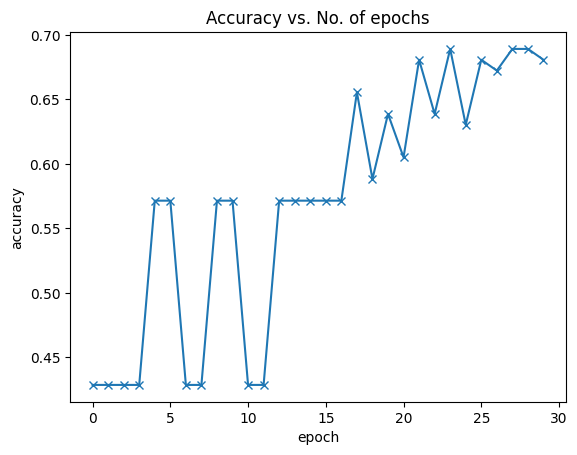

In [15]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)



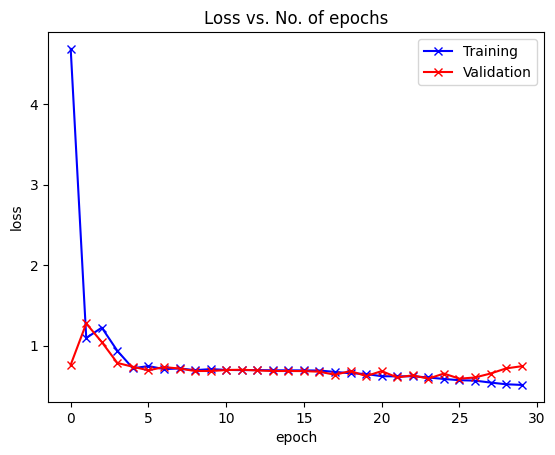

In [16]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)